#  Multi-label Classification 1

## Importing required packages

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn import metrics
from sklearn.metrics import accuracy_score, make_scorer, f1_score
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
from random import shuffle

## Task 0: Load the Medical Dataset

In [11]:
import pandas as pd

df = pd.read_csv('../data/Medical.csv',delimiter=';',encoding ='latin1')

df.head() 

,A,B,AC,BC,AD,BD,AF,BF,01/01/2002,1-1/2-year,...,Class-35-493_90,Class-36-788_30,Class-37-753_3,Class-38-593_89,Class-39-758_6,Class-40-741_90,Class-41-591,Class-42-599_7,Class-43-279_12,Class-44-786_07
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
X = df.iloc[:, 0:-45]

In [13]:
y = df.iloc[:,-45:]
y

,Class-0-593_70,Class-1-079_99,Class-2-786_09,Class-3-759_89,Class-4-753_0,Class-5-786_2,Class-6-V72_5,Class-7-511_9,Class-8-596_8,Class-9-599_0,...,Class-35-493_90,Class-36-788_30,Class-37-753_3,Class-38-593_89,Class-39-758_6,Class-40-741_90,Class-41-591,Class-42-599_7,Class-43-279_12,Class-44-786_07
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
975,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
976,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
labels =list(y.columns)

In [15]:
#labels = ['amazed-suprised', 'happy-pleased', 'relaxing-calm', 'quiet-still', 'sad-lonely', 'angry-aggresive']

In [16]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size = 0.7)

In [17]:
# Custom accuracy score based on hamming loss implementation

def get_accuracy_score(y_test,y_pred):
    
    if 'numpy' not in str(type(y_pred)):
        y_pred = y_pred.to_numpy()
        
    if 'numpy' not in str(type(y_test)):
        y_test = y_test.to_numpy()
    
    
    assert(y_test.shape == y_pred.shape)
    
    if y_pred.shape[1] <= 5: #For a smaller number of labels, a ratio of half the labels being correct is good enough
        ratio = 0.5
    else:
        ratio = 0.7 #For a number of labels, at least 70% of the predicted labels must be correct
    
    acc_rows = []
    
    for i in range(len(y_test)):
        acc_rows.append(np.count_nonzero(y_test[i]==y_pred[i]))
#         acc_rows.append(np.count_nonzero(y_test.iloc[i,:].values==y_pred.iloc[i,:].values)) #Count the number of matches
        
    acc_rows = [1 if x/y_pred.shape[1] >= ratio else 0 for x in acc_rows] #1 if ratio of match in a row is greater than ratio, else 0
    return sum(acc_rows)/len(acc_rows) # Mean accuracy


## Task 1: Implement the Binary Relevance Algorithm

In [18]:
class BinaryRelevanceClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, base_model=LogisticRegression()):
        self.base_model = base_model #base model - by default logistic regression
    
    def fit(self, X, y):
        self.model_list_ = []
        for column in y:  #For every label in y, fit the model independently
            clf = clone(self.base_model) #Clone the base model to avoid shallow copy
            A,b = check_X_y(X,y[column])
            clf.fit(A,b) #fit the model for the particular label value
            self.model_list_.append(clf) #Add the model to the saved model list
            
    def predict(self,X):
        check_is_fitted(self, ['model_list_']) 
        X = check_array(X)
        y_pred = pd.DataFrame() #Create a dataframe to save predictions
        i = 1
        for model in self.model_list_: #Make predictions for each label, using the corresponding mdodel
            y_pred_class = model.predict(X) 
            y_pred[i] = y_pred_class #Add current prediction to dataframe
            i+=1
        return y_pred.to_numpy() #return final predictions
    
    def predict_proba(self,X):
        check_is_fitted(self, ['model_list_']) #Check if model list is present
        X = check_array(X)
        y_pred = pd.DataFrame()
        i = 1
        for model in self.model_list_:
            y_pred_class = model.predict_proba(X) #Call predict_proba of the each base model
            y_pred[i] = [one_prob[1] for one_prob in y_pred_class] #Add the probability of 1 to the dataframe
            i+=1
        return y_pred.to_numpy() #return final probabilities

# 1.1 RandomForestClassifier

 RandomForestClassifier Accuracy (hamming loss) of  = 100.000000 %
--------------------------------------------------------------------------------------------------------------
RandomForestClassifier Accuracy of  = 50.000000 %
RandomForestClassifier F1 Score of  = 70.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.70      0.81        37
           1       1.00      0.40      0.57         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.89      0.86      0.87        76
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.80      0.89      0.84        27
          10    

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


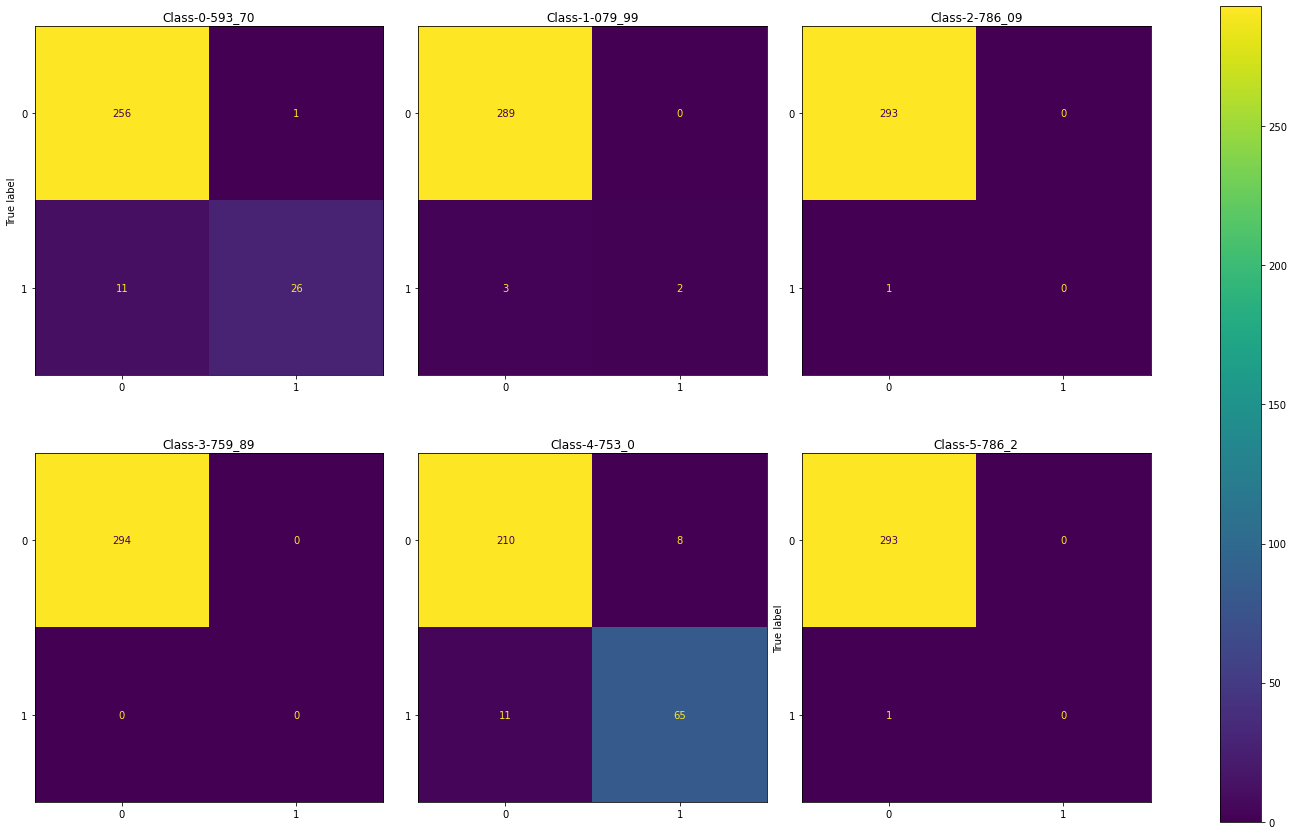

In [19]:
binclf = BinaryRelevanceClassifier(base_model=RandomForestClassifier())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" RandomForestClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("RandomForestClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("RandomForestClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [20]:
y_pred_BR

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=int64)

# 1.2 GaussianNB

 GaussianNB Accuracy (hamming loss) of  = 100.000000 %
--------------------------------------------------------------------------------------------------------------
GaussianNB Accuracy of  = 13.605442 %
GaussianNB F1 Score of  = 41.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.52      0.38      0.44        37
           1       1.00      0.60      0.75         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.51      0.63      0.56        76
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.44      0.52      0.47        27
          10       0.00      0.00      0.00         

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


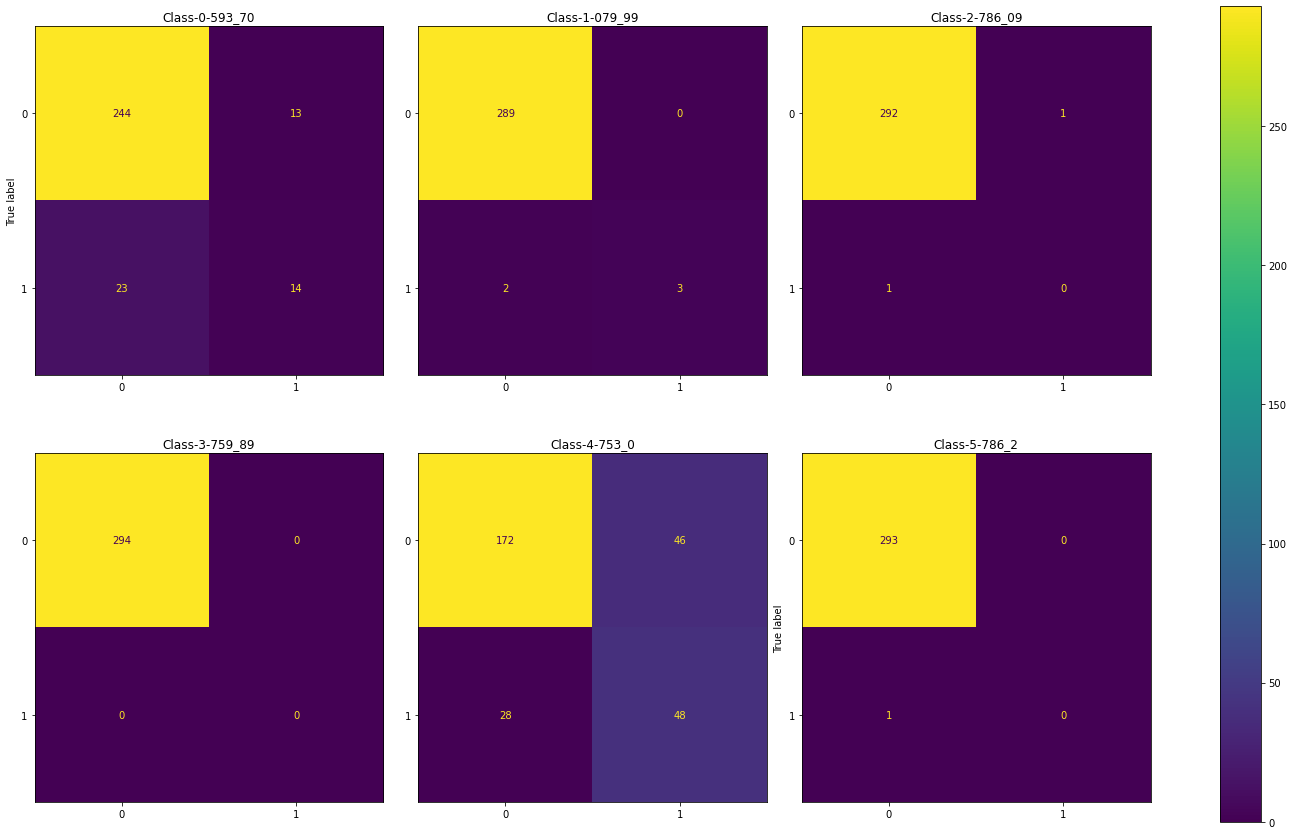

In [21]:
binclf = BinaryRelevanceClassifier(base_model=GaussianNB())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" GaussianNB Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("GaussianNB Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("GaussianNB F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 1.3 DecisionTreeClassifier

 DecisionTreeClassifier Accuracy (hamming loss) of  = 100.000000 %
--------------------------------------------------------------------------------------------------------------
DecisionTreeClassifier Accuracy of  = 61.904762 %
DecisionTreeClassifier F1 Score of  = 79.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.81      0.86        37
           1       1.00      0.80      0.89         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.91      0.84      0.88        76
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.71      0.74      0.73        27
          10    

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


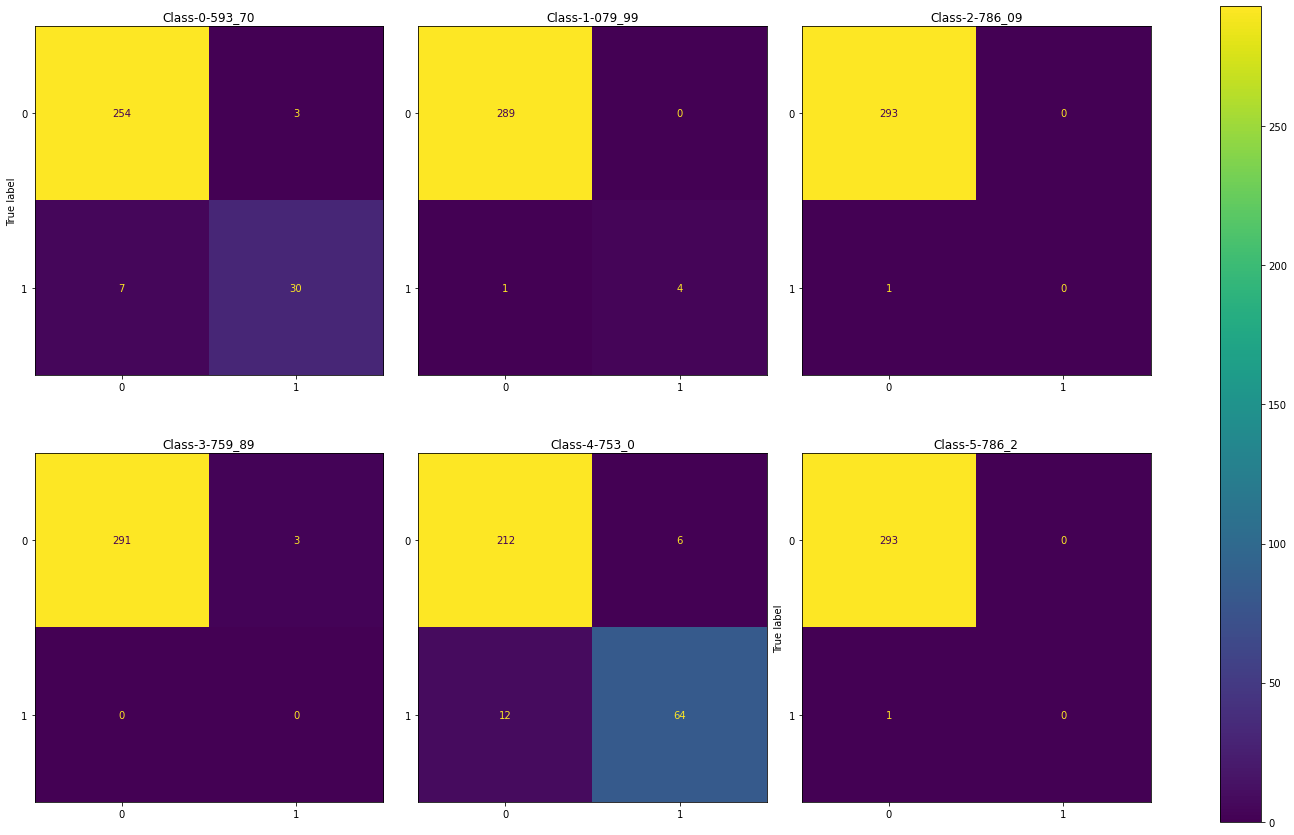

In [22]:
binclf = BinaryRelevanceClassifier(base_model=DecisionTreeClassifier())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" DecisionTreeClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("DecisionTreeClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("DecisionTreeClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 1.4 Support vector machine

# 1.5 ExtraTreesClassifier

 ExtraTreesClassifier Accuracy (hamming loss) of  = 100.000000 %
--------------------------------------------------------------------------------------------------------------
ExtraTreesClassifier Accuracy of  = 53.061224 %
ExtraTreesClassifier F1 Score of  = 73.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.68      0.81        37
           1       1.00      0.60      0.75         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.90      0.84      0.87        76
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.79      0.81      0.80        27
          10       0.0

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


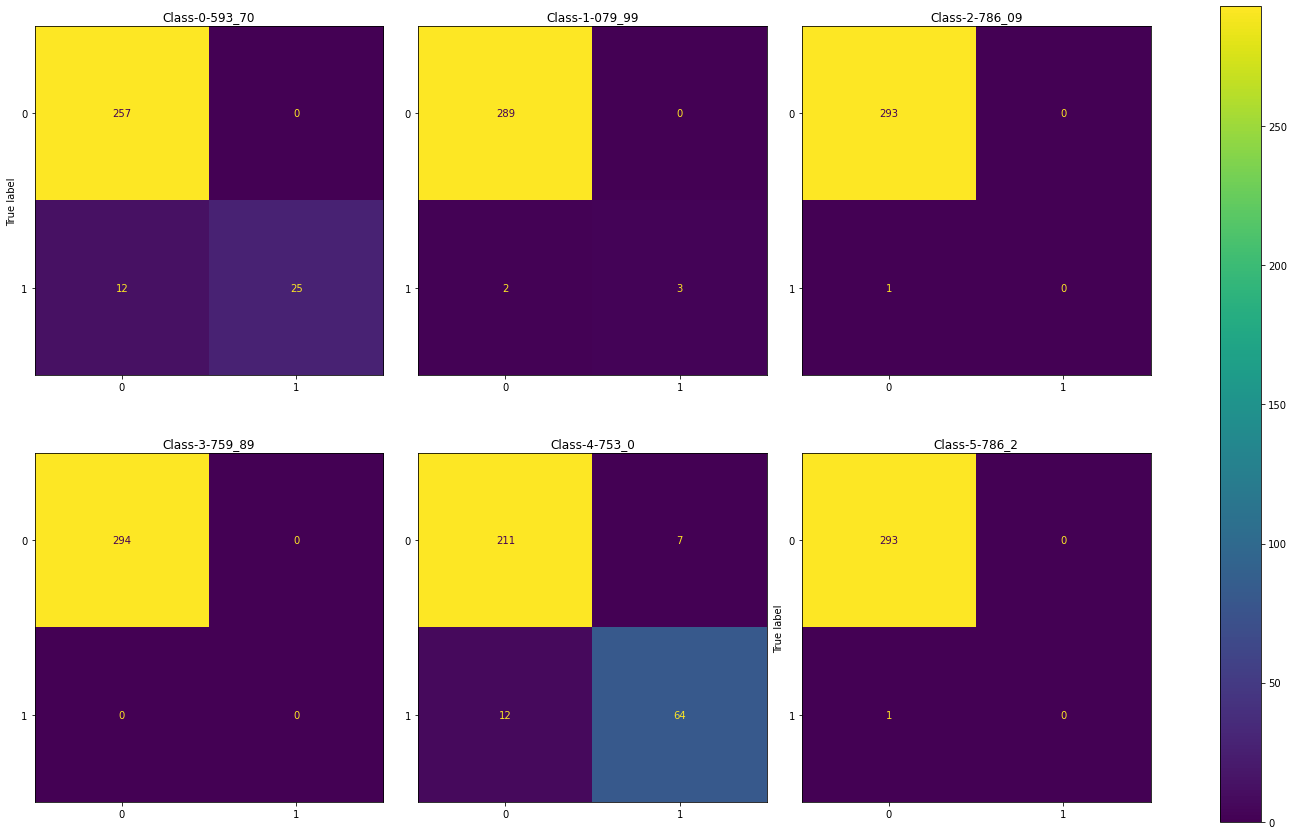

In [26]:
# 
binclf = BinaryRelevanceClassifier(base_model=ExtraTreesClassifier())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" ExtraTreesClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("ExtraTreesClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("ExtraTreesClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 1.6 AdaBoostClassifier

 AdaBoostClassifier Accuracy (hamming loss) of  = 100.000000 %
--------------------------------------------------------------------------------------------------------------
AdaBoostClassifier Accuracy of  = 60.204082 %
AdaBoostClassifier F1 Score of  = 76.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.73      0.74        37
           1       1.00      1.00      1.00         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.88      0.89      0.89        76
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.81      0.78      0.79        27
          10       0.40     

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


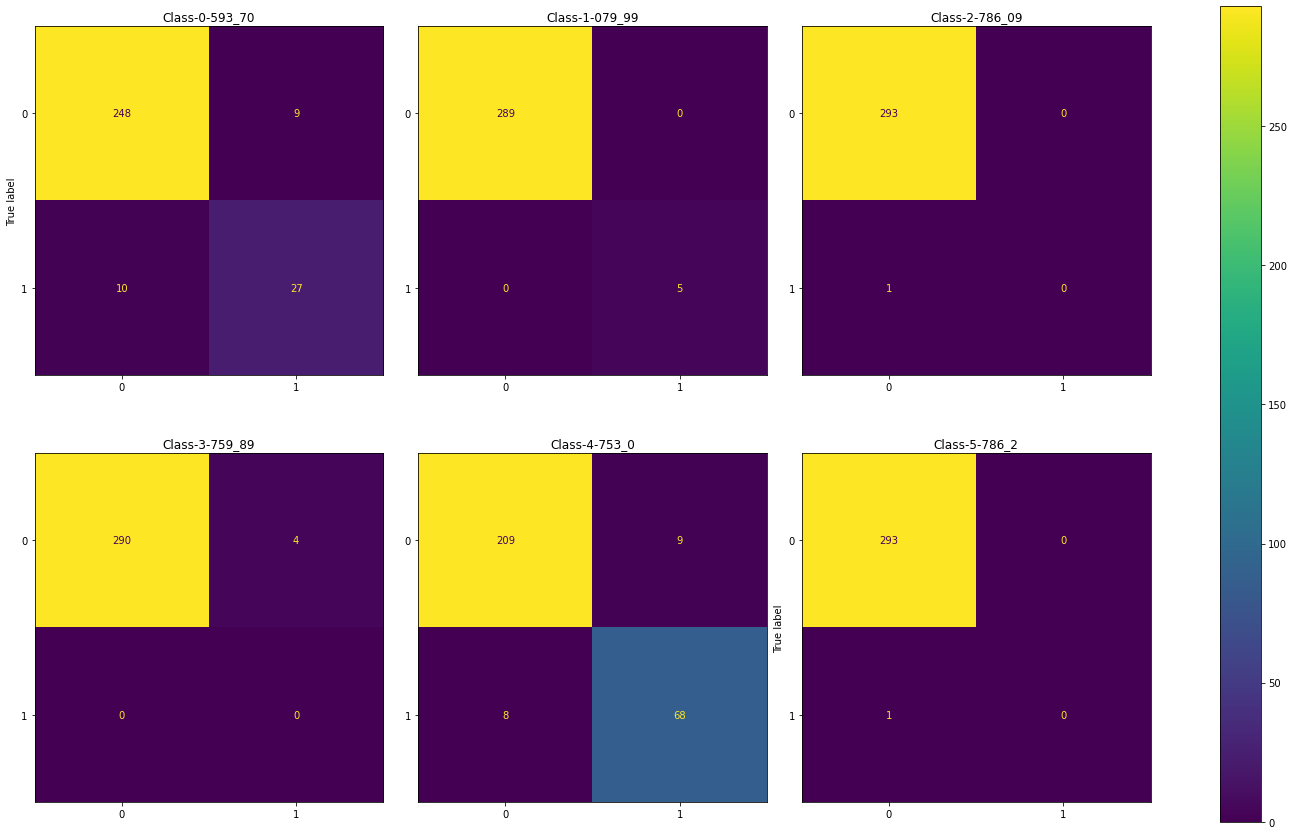

In [27]:

binclf = BinaryRelevanceClassifier(base_model=AdaBoostClassifier())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" AdaBoostClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("AdaBoostClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("AdaBoostClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

## Task 2: Implement the Classifier Chains Algorithm

In [28]:
class ClassifierChains(BaseEstimator, ClassifierMixin):
    
    def __init__(self, base_model=LogisticRegression(), order = None, undersample=False):
        self.base_model = base_model # The base estimator
        self.order = order # Order of labels in which the labels are to be sent to the classifier
        self.undersample = undersample # Whether or not to undersample
        
    def fit(self, X, y):
        X_cpy = X.copy()
        y_cpy = y.copy()
        self.order_shuffle = None
        self.base_order = list(range(len(y.columns)))
        
        if self.order is None:
            self.order_shuffle = list(range(len(y_cpy.columns))) # Same order as input
            
        elif self.order == 'random':
            self.order_shuffle = list(range(len(y_cpy.columns))) # Random label order
            random.shuffle(self.order_shuffle)
            print(self.order_shuffle)
            
        else:
            if len(self.order) == len(y.columns) and all(isinstance(item, int) for item in self.order):
                self.order_shuffle = self.order # Label order given by user
        
        y_cpy = y_cpy.iloc[:,self.order_shuffle] # Shuffle y according to label order
        
        
        self.model_list_ = []
        for column in y_cpy:
            X_cpy.reset_index(drop=True, inplace=True)
            y_cpy.reset_index(drop=True, inplace=True)
            
            X_copy = X_cpy.copy()
            
            if self.undersample:
                concat_x_y = X_copy.join(y_cpy[column]) #Concat X and the label to perform undersampling
                label_0, label_1 = sum(y_cpy[column]==0), sum(y_cpy[column])

                ratio = label_1/label_0 #Check the ratio of 1s to 0s in a target

                '''Here, we undersample only when the difference between 1 and 0 is quite large, 
                that is if the number of the majority class is more than double the number of the minority class'''

                if ratio < 0.5: # Undersample using pd.sample on label 0
                    xy_label_1 = concat_x_y[concat_x_y[column]==1]
                    xy_label_0 = concat_x_y[concat_x_y[column]==0].sample(label_1)
                    concat_x_y = pd.concat([xy_label_0, xy_label_1], axis=0)

                elif ratio >= 2: # Undersample using pd.sample on label 1
                    xy_label_1 = concat_x_y[concat_x_y[column]==1].sample(label_0) 
                    xy_label_0 = concat_x_y[concat_x_y[column]==0]
                    concat_x_y = pd.concat([xy_label_0, xy_label_1], axis=0)              

                #Separate concatenated dataset into X and y
                X_copy = concat_x_y.iloc[:,:-1]
                y_column = concat_x_y.iloc[:,-1]

            else:
                y_column = y_cpy[column]
                
            clf = clone(self.base_model)
            A,b = check_X_y(X_copy, y_column)
            clf.fit(A,b)  # Fit model to the (undersampled if true) dataset
            self.model_list_.append(clf)   # Append model to list
            y_col = pd.DataFrame(y_cpy[column])
            X_cpy = pd.concat([X_cpy, y_col], axis=1)  # Concatenate current label to X
            
            
    def predict(self,X):
        X_cpy = X.copy()
        X_cpy.reset_index(drop=True, inplace=True)
        check_is_fitted(self, ['model_list_']) # Check if the model list is present
        y_pred = pd.DataFrame() # Create a dataframe to save predictions
        i = 0
        for model in self.model_list_: # Make predictions for each label, using the corresponding mdodel
            X_cpy = check_array(X_cpy)
            y_pred_class = model.predict(X_cpy) # Predict current label
            y_pred[self.order_shuffle[i]] = y_pred_class # Save the predicted class according to our label order
            
            X_cpy = np.column_stack((X_cpy, y_pred_class)) # Append the predicted column to X test
            i+=1
            
        y_pred = y_pred.loc[:,self.base_order] # Return according to original order
        return y_pred.to_numpy() # Return as numpy array
    
    def predict_proba(self,X):
        X_cpy = X.copy()
        X_cpy.reset_index(drop=True, inplace=True)
        check_is_fitted(self, ['model_list_']) #Check if the model list is present
        y_pred = pd.DataFrame() # Create a dataframe to save predictions
        i = 0
        for model in self.model_list_: # Make prediction probabilities for each label, using the corresponding mdodel
            X_cpy = check_array(X_cpy)
            y_pred_class = model.predict(X_cpy) # Predict current label
            y_pred_class_proba = model.predict_proba(X_cpy) # Predict probabilties using current model
            y_pred[self.order_shuffle[i]] = [one_prob[1] for one_prob in y_pred_class_proba] # Save the probabilities of 1 according to our label order
            X_cpy = np.column_stack((X_cpy, y_pred_class)) # Append prediction to X test
            i+=1
        y_pred = y_pred.loc[:,self.base_order] # Return probabilities according to original order
        return y_pred.to_numpy() # Return as numpy

# 2.1 RandomForestClassifier

 RandomForestClassifier Accuracy (hamming loss) of  = 100.000000 %
--------------------------------------------------------------------------------------------------------------
RandomForestClassifier Accuracy of  = 50.340136 %
RandomForestClassifier F1 Score of  = 70.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.65      0.79        37
           1       1.00      0.20      0.33         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.89      0.84      0.86        76
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.86      0.89      0.87        27
          10    

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


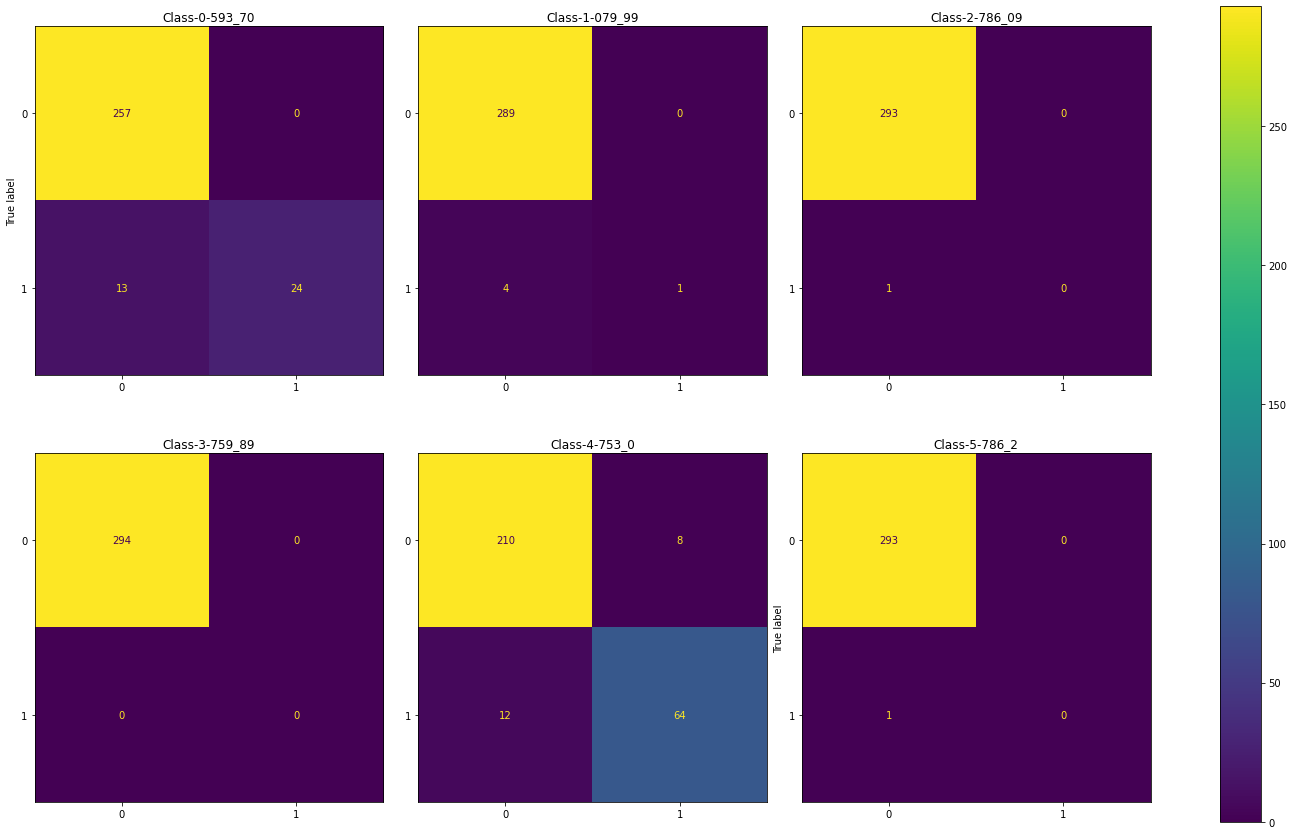

In [29]:

class_chain = ClassifierChains(base_model=RandomForestClassifier())
class_chain.fit(X_train,y_train)

y_pred_cc = class_chain.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" RandomForestClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("RandomForestClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("RandomForestClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 2.2 GaussianNB

 GaussianNB Accuracy (hamming loss) of  = 100.000000 %
--------------------------------------------------------------------------------------------------------------
GaussianNB Accuracy of  = 14.625850 %
GaussianNB F1 Score of  = 41.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.52      0.38      0.44        37
           1       1.00      0.60      0.75         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.51      0.63      0.56        76
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.44      0.52      0.47        27
          10       0.00      0.00      0.00         

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


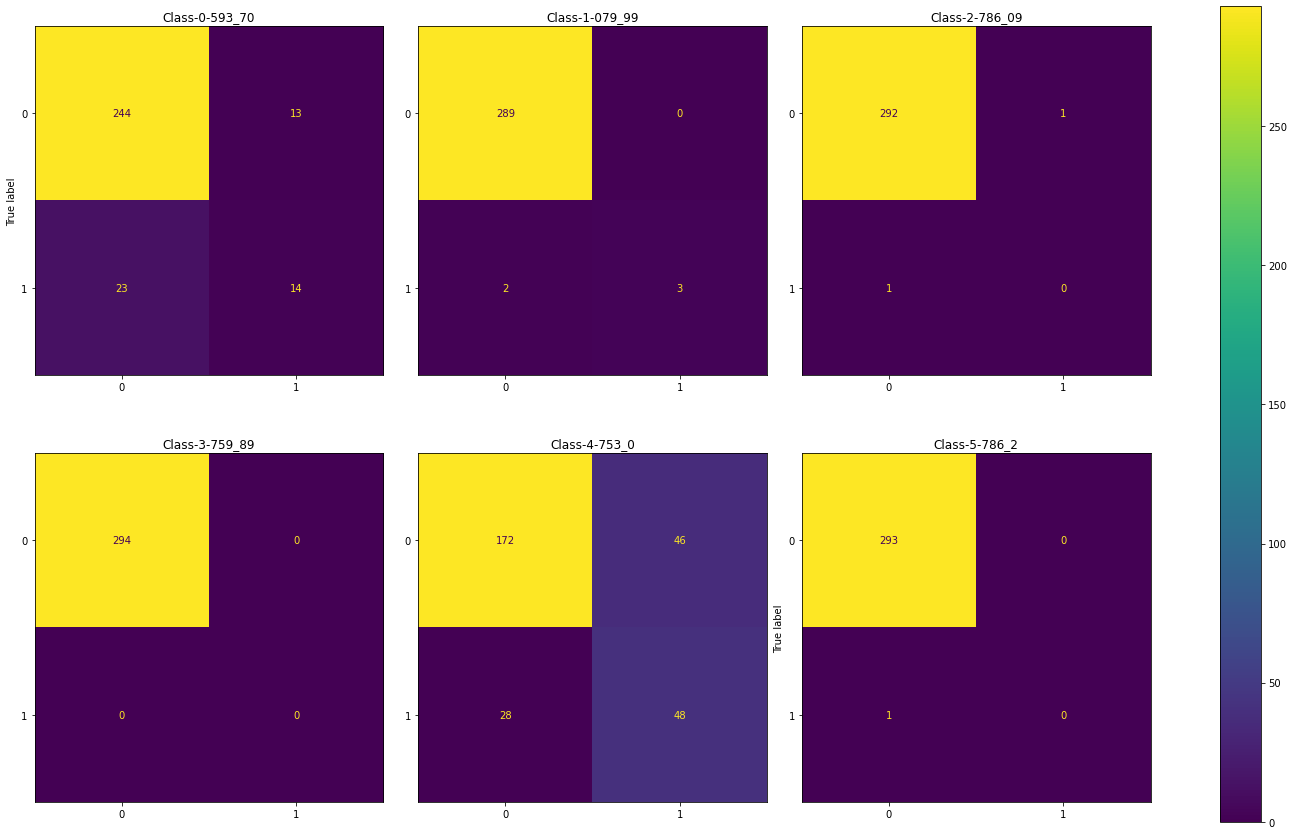

In [30]:
class_chain = ClassifierChains(base_model=GaussianNB())
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" GaussianNB Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("GaussianNB Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("GaussianNB F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()  

# 2.3 DecisionTreeClassifier

 DecisionTreeClassifier Accuracy (hamming loss) of  = 100.000000 %
--------------------------------------------------------------------------------------------------------------
DecisionTreeClassifier Accuracy of  = 61.224490 %
DecisionTreeClassifier F1 Score of  = 77.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.81      0.86        37
           1       1.00      0.80      0.89         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.89      0.83      0.86        76
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.67      0.74      0.70        27
          10    

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


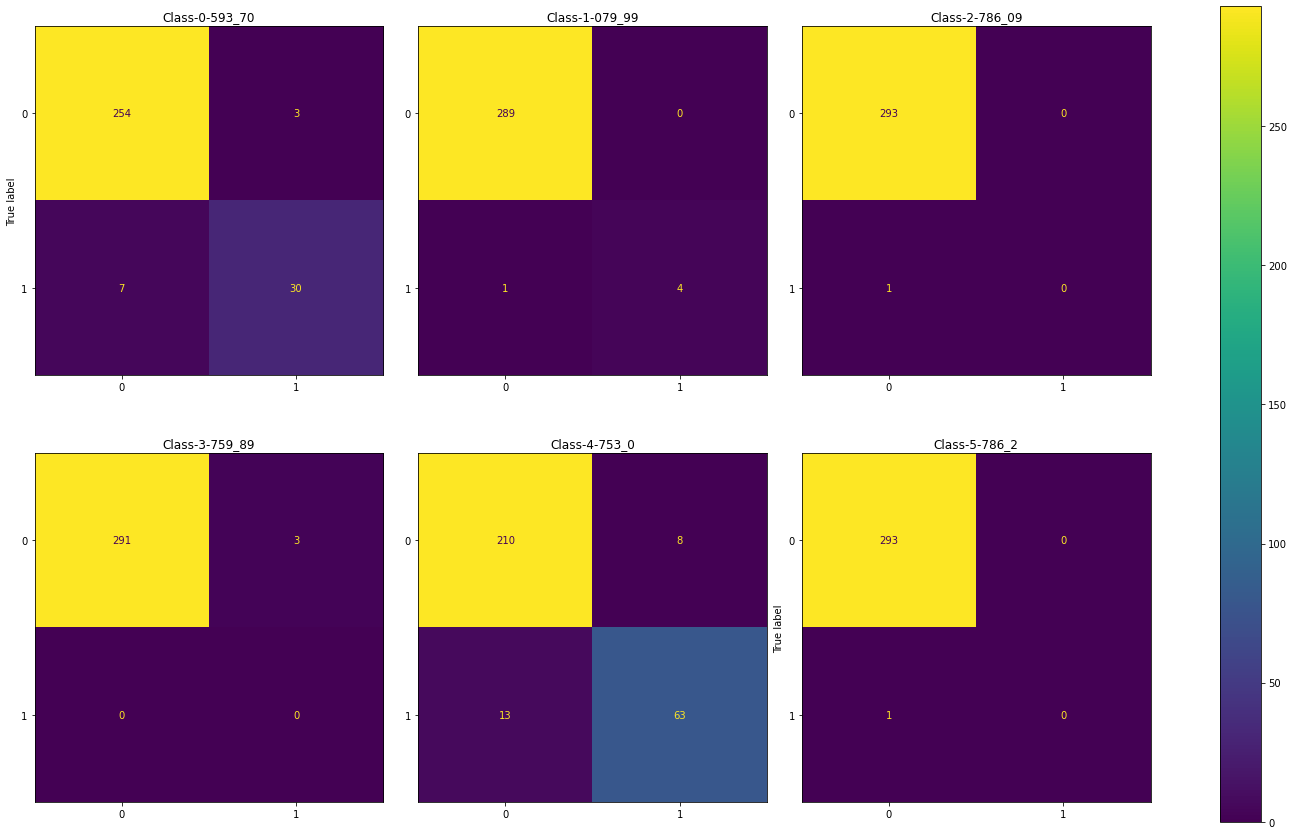

In [31]:
class_chain = ClassifierChains(base_model=DecisionTreeClassifier())
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" DecisionTreeClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("DecisionTreeClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("DecisionTreeClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()  

# 2.4 Support Vector Machine

# 2.5 ExtraTreesClassifier

 ExtraTreesClassifier Accuracy (hamming loss) of  = 100.000000 %
--------------------------------------------------------------------------------------------------------------
ExtraTreesClassifier Accuracy of  = 54.421769 %
ExtraTreesClassifier F1 Score of  = 73.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.76      0.86        37
           1       1.00      0.60      0.75         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.89      0.86      0.87        76
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.79      0.81      0.80        27
          10       0.0

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


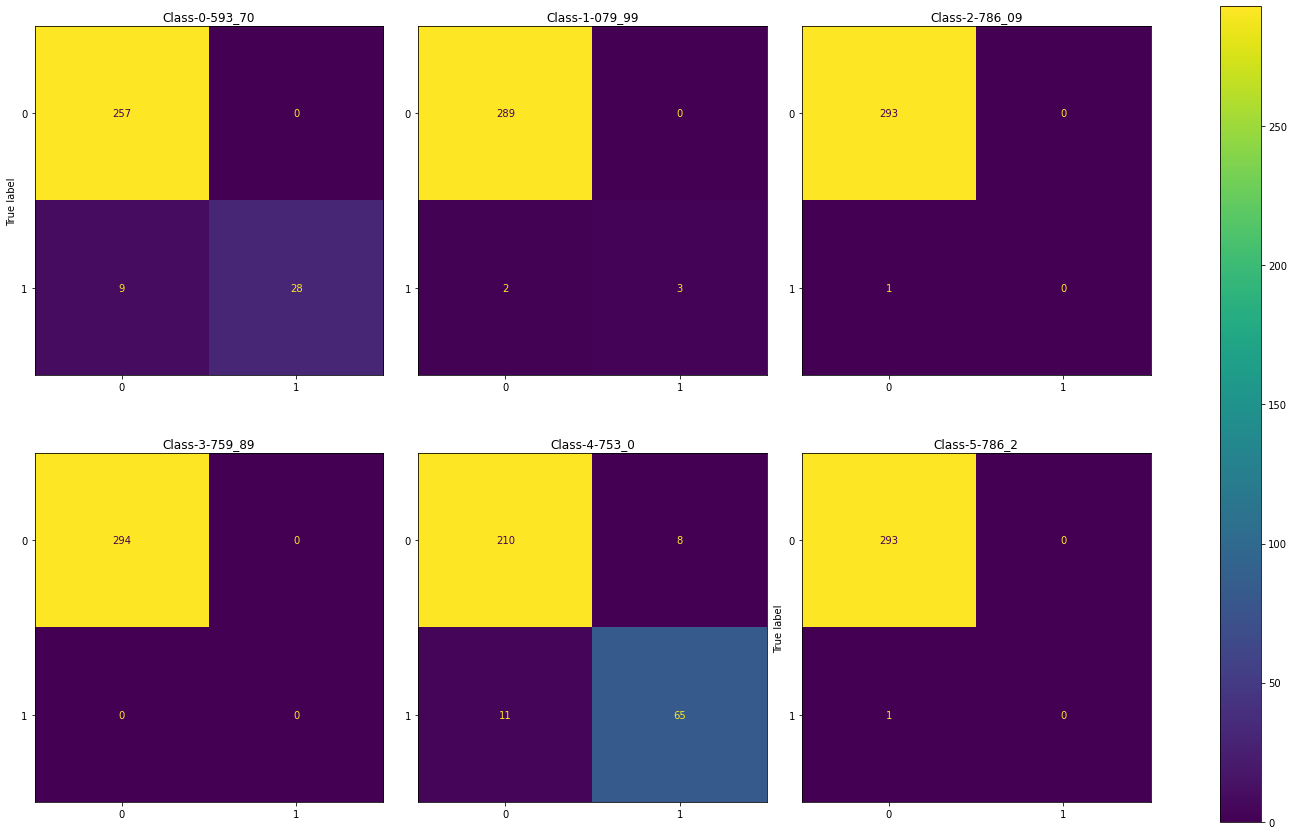

In [33]:
class_chain = ClassifierChains(base_model=ExtraTreesClassifier())
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" ExtraTreesClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("ExtraTreesClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("ExtraTreesClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()  

# 2.6 AdaBoostClassifier

 AdaBoostClassifier Accuracy (hamming loss) of  = 100.000000 %
--------------------------------------------------------------------------------------------------------------
AdaBoostClassifier Accuracy of  = 62.585034 %
AdaBoostClassifier F1 Score of  = 75.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.73      0.74        37
           1       1.00      1.00      1.00         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.88      0.88      0.88        76
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.81      0.78      0.79        27
          10       0.14     

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


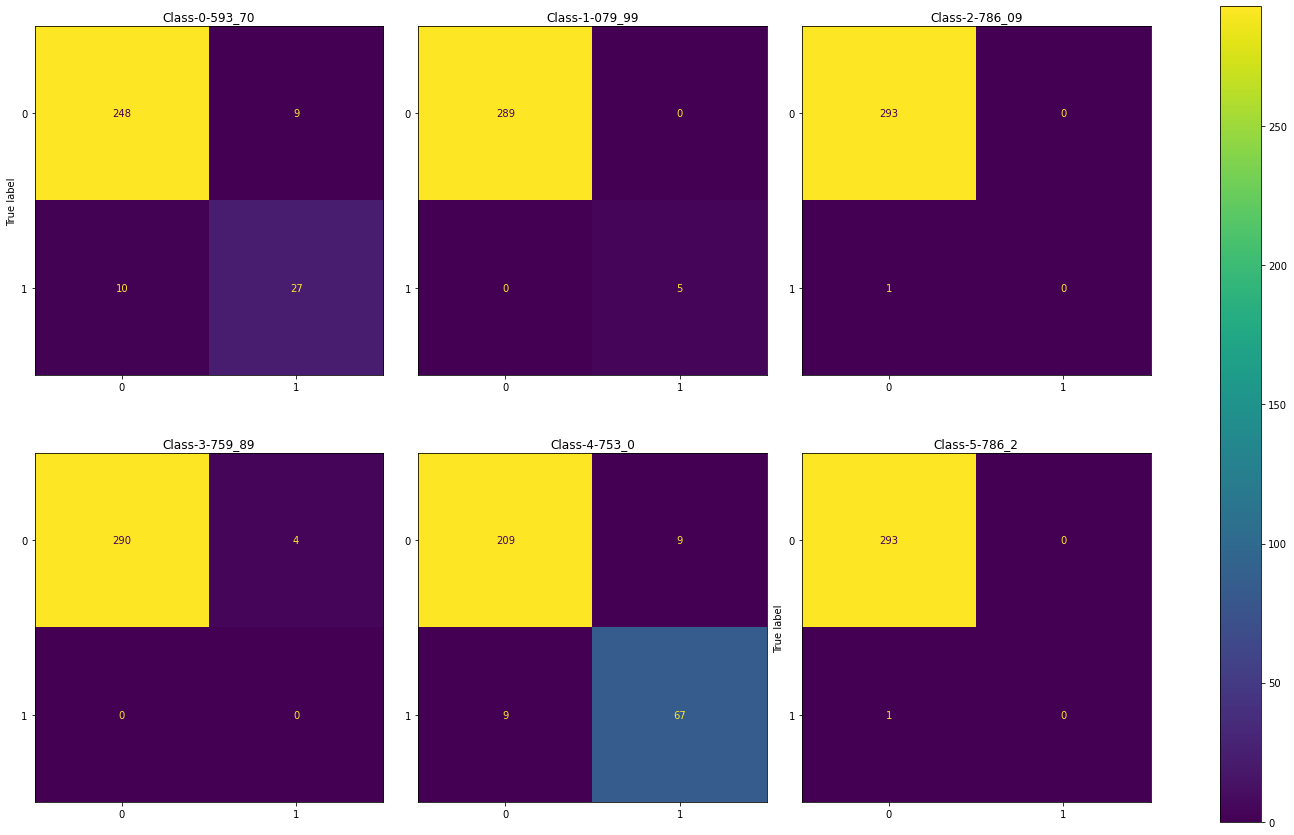

In [34]:
class_chain = ClassifierChains(base_model=AdaBoostClassifier())
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" AdaBoostClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("AdaBoostClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("AdaBoostClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()  

# Task 3: Implement the LabelPowerset Algorithm


# 3.1 AdaBoostClassifier

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------------------------
AdaBoostClassifier Accuracy of  = 10.884354 %
AdaBoostClassifier F1 Score of  = 11.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00        76
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.13      0.96      0.23        27
          10       0.00      0.00      0.00         8
          11       0.00      0.00    

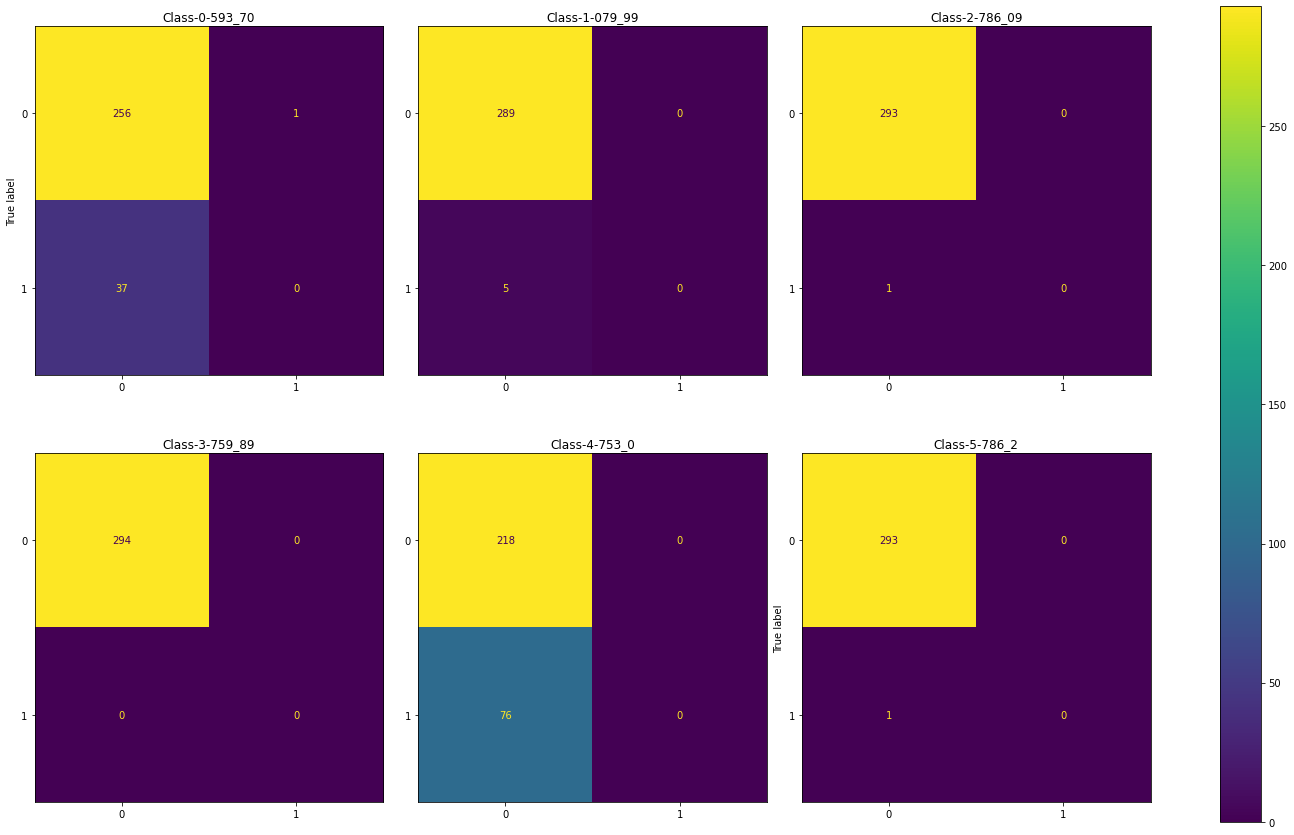

In [35]:
cla_LPowerset = LabelPowerset(AdaBoostClassifier())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
#acc_2 = get_accuracy_score(y_test,y_pred_LP) # Default accuracy score not used because it performs exact matching
#print(" AdaBoostClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("AdaBoostClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("AdaBoostClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()  

# 3.2 ExtraTreesClassifier

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------------------------
ExtraTreesClassifier Accuracy of  = 62.244898 %
ExtraTreesClassifier F1 Score of  = 74.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        37
           1       1.00      0.80      0.89         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.83      0.86      0.84        76
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.71      0.93      0.81        27
          10       0.00      0.00      0.00         8
          11       0.00      0.00

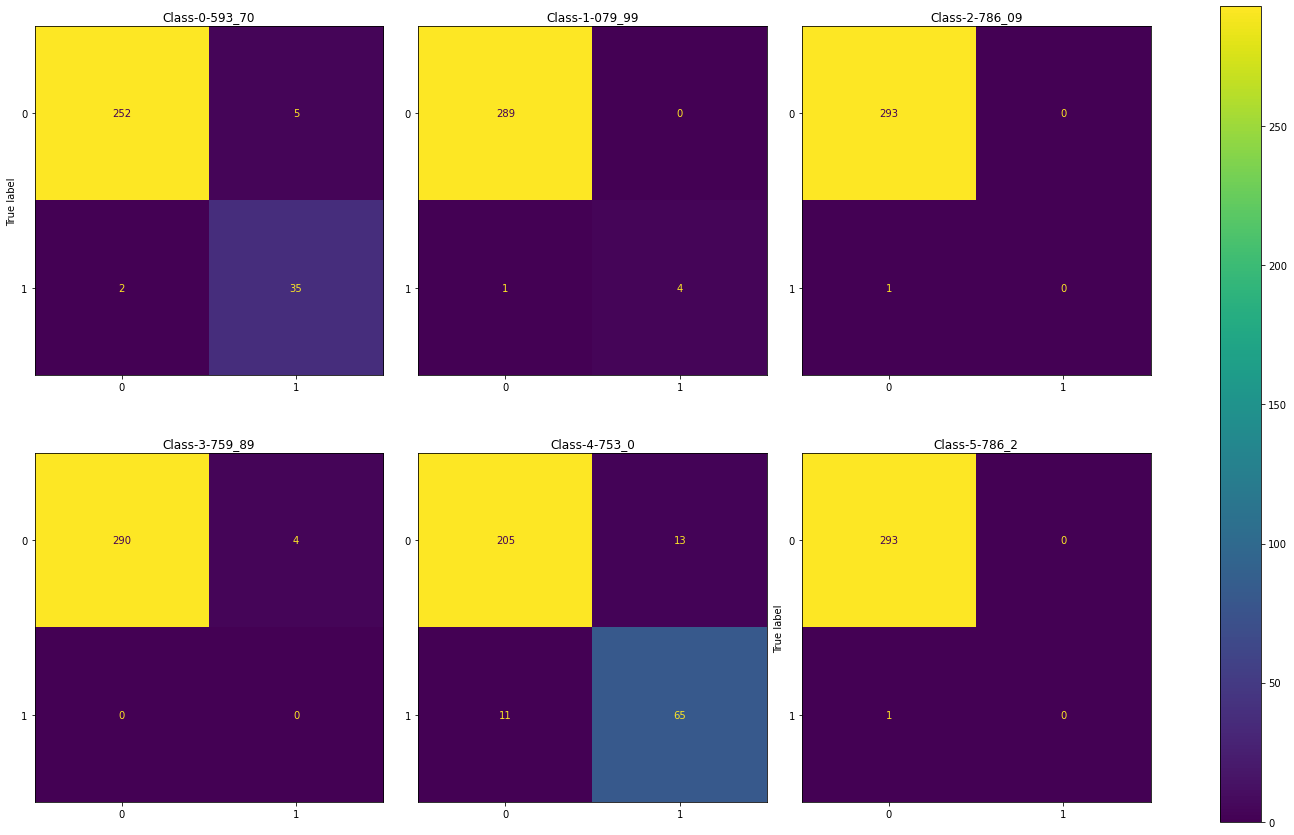

In [36]:

cla_LPowerset = LabelPowerset(ExtraTreesClassifier())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("ExtraTreesClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("ExtraTreesClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 3.3 Support Vector Machine

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


--------------------------------------------------------------------------------------------------------------
Support Vector Machine Accuracy of  = 67.006803 %
Support Vector Machine F1 Score of  = 77.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.89      0.90        37
           1       1.00      0.80      0.89         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.93      0.89      0.91        76
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.76      0.81      0.79        27
          10       0.67      0.25      0.36         8
          11       0.00      

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


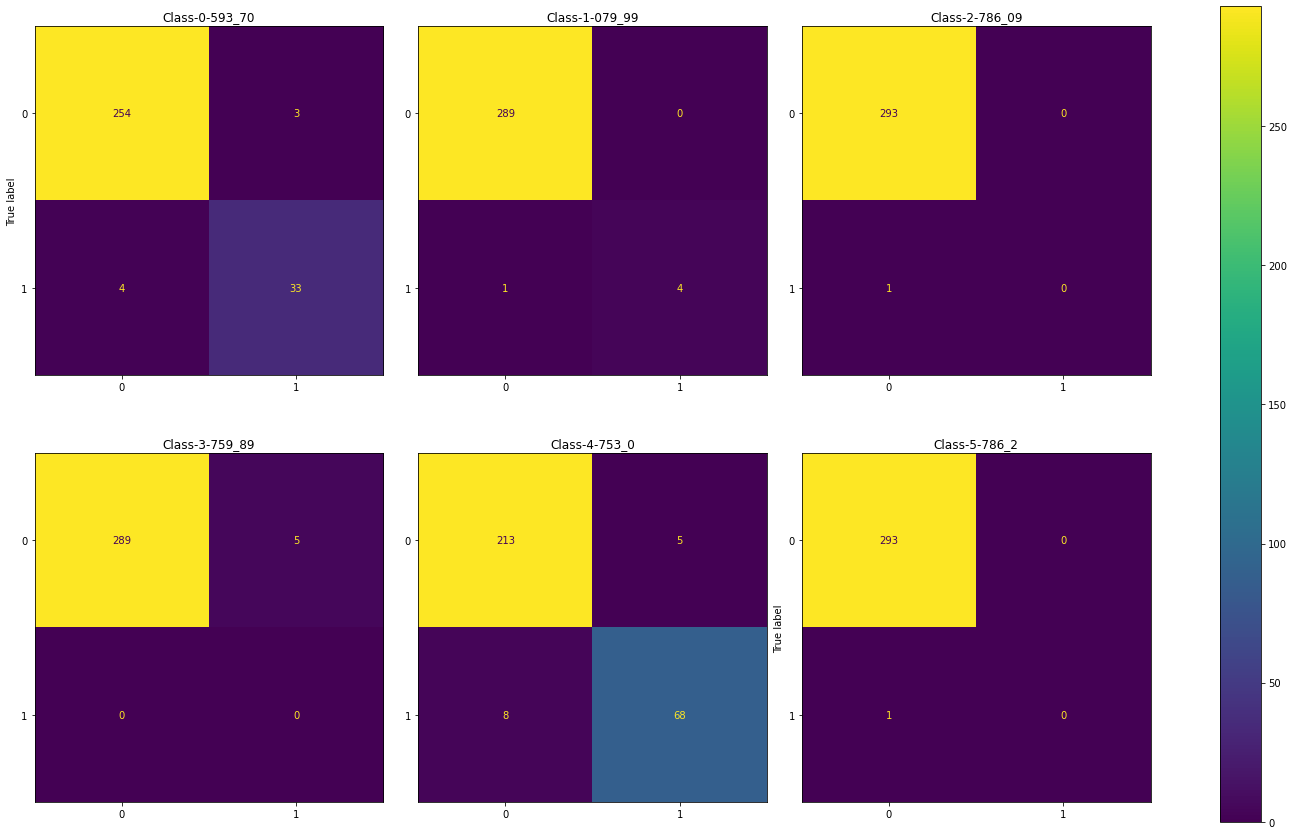

In [37]:

cla_LPowerset = LabelPowerset(svm.SVC(kernel='linear', C = 1.0))
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("Support Vector Machine Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("Support Vector Machine F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 3.4 DecisionTreeClassifier

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------------------------
DecisionTreeClassifier Accuracy of  = 61.564626 %
DecisionTreeClassifier F1 Score of  = 72.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.89      0.85        37
           1       1.00      0.60      0.75         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.90      0.86      0.88        76
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.73      0.89      0.80        27
          10       0.00      0.00      0.00         8
          11       0.40      

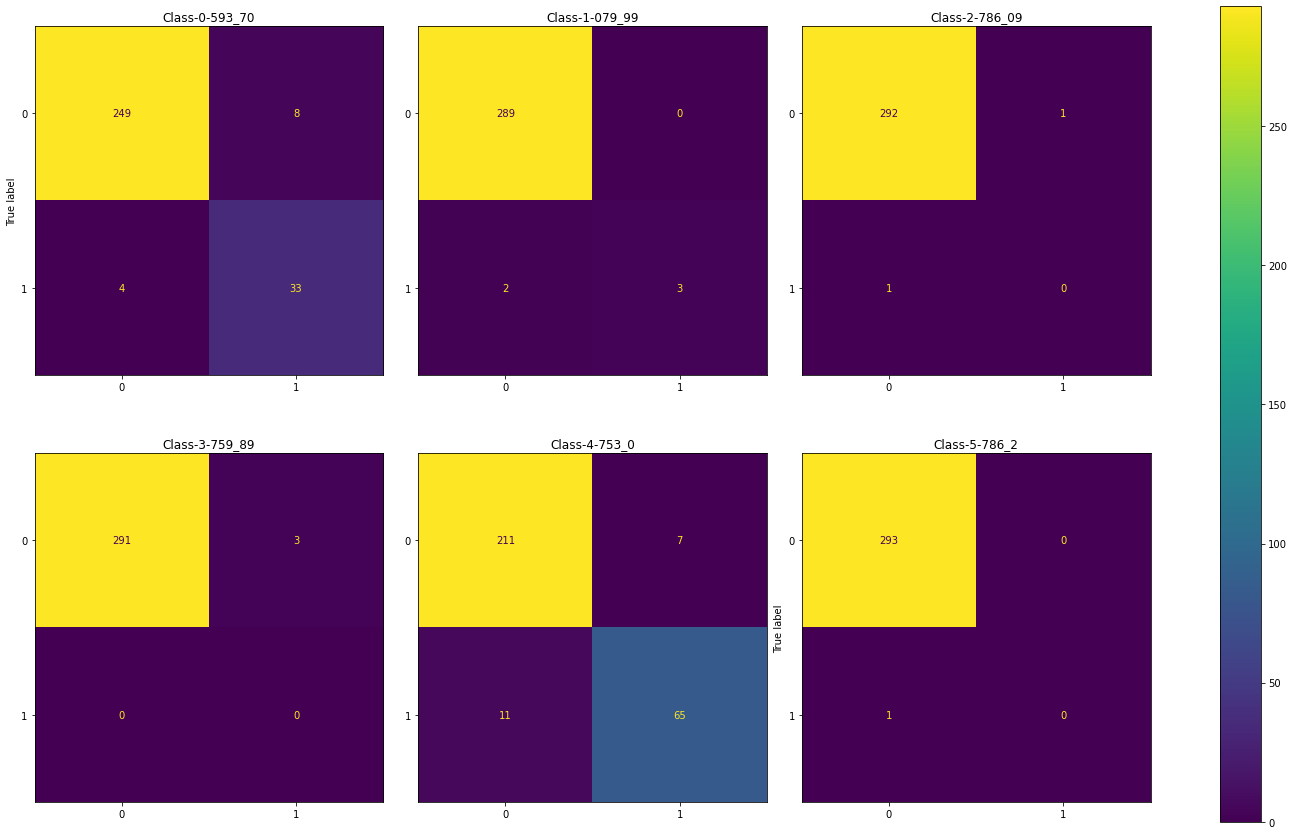

In [38]:

cla_LPowerset = LabelPowerset(DecisionTreeClassifier())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("DecisionTreeClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("DecisionTreeClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 3.5 GaussianNB

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


--------------------------------------------------------------------------------------------------------------
GaussianNB Accuracy of  = 41.156463 %
GaussianNB F1 Score of  = 53.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.56      0.81      0.66        37
           1       1.00      0.60      0.75         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.71      0.71      0.71        76
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.51      0.67      0.58        27
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00         4

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


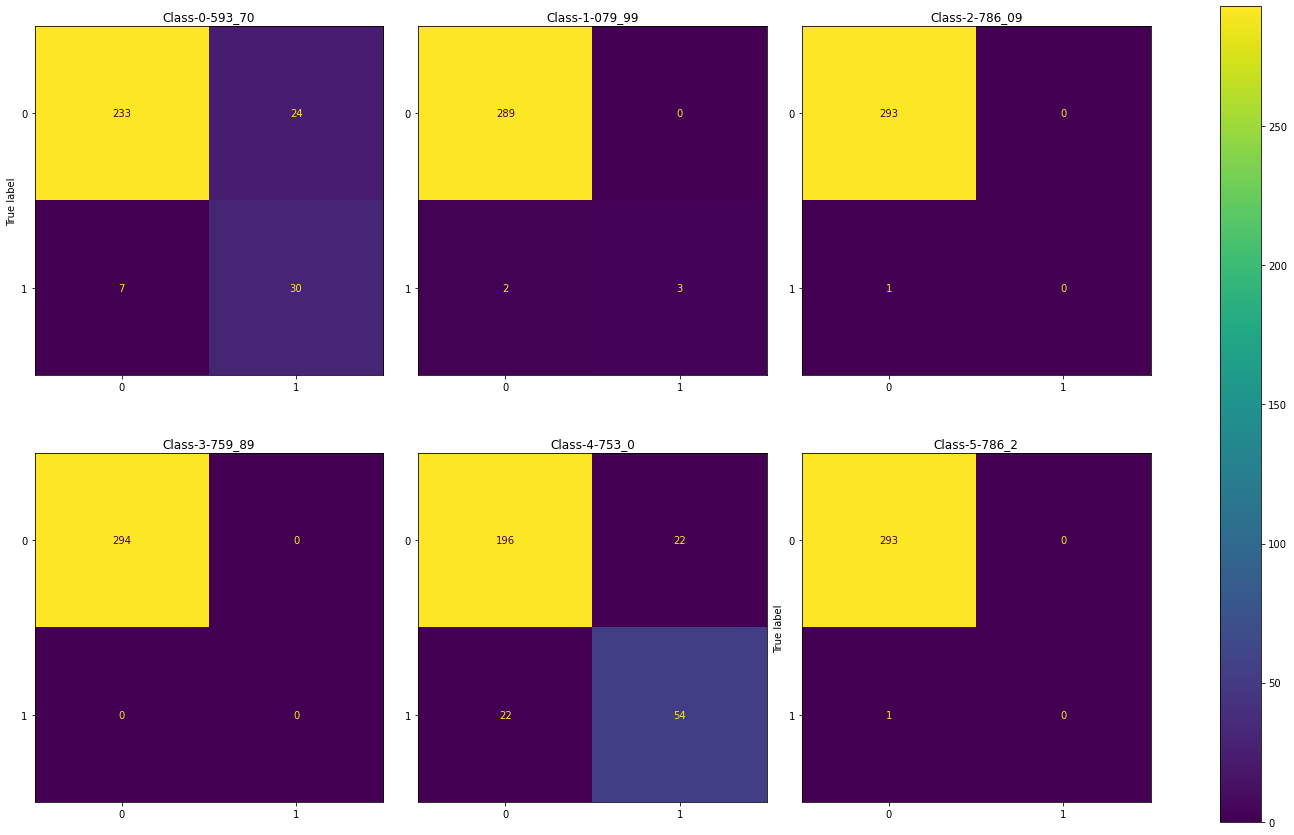

In [39]:

cla_LPowerset = LabelPowerset(GaussianNB())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("GaussianNB Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("GaussianNB F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 3.6 RandomForestClassifier

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------------------------
RandomForestClassifier Accuracy of  = 62.244898 %
RandomForestClassifier F1 Score of  = 73.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.95      0.88        37
           1       1.00      0.60      0.75         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.85      0.84      0.85        76
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.68      0.93      0.78        27
          10       0.00      0.00      0.00         8
          11       0.00      

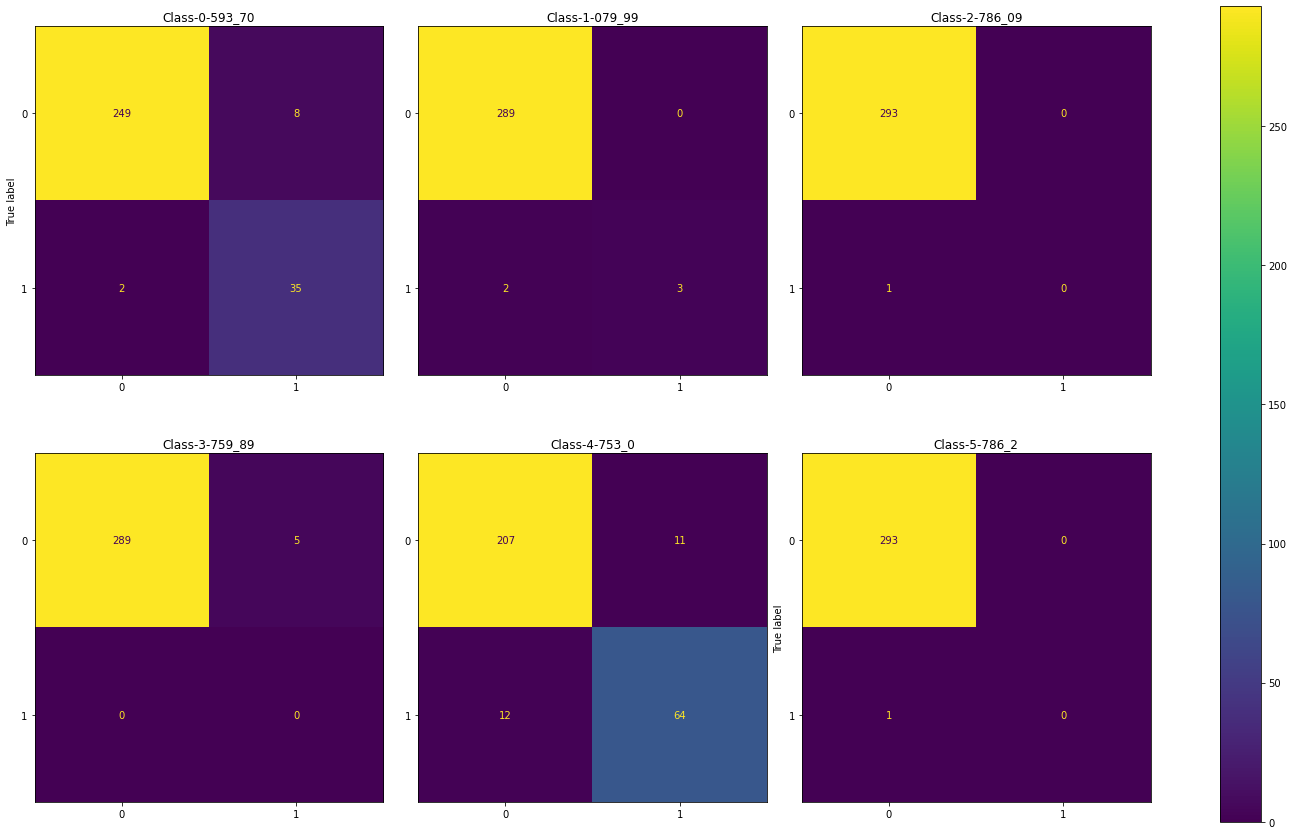

In [40]:

cla_LPowerset = LabelPowerset(RandomForestClassifier())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("RandomForestClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("RandomForestClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()